In [1]:
import numpy as np
import cv2
import glob
from sklearn.cluster import KMeans
import os
from text_detect import *

try:
    from PIL import Image
except ImportError:
    import Image

In [2]:
# List of a variety of files for preliminary testing
files_to_test = ['100082743.png','290066548.png','51sm64mnQcL._SX342_.jpg','advance-payment-against-proforma-invoice-non-b-nw.jpg','argentina-certificate-of-origin.jpg','ARITACER1.jpg','b3bab39a63b38db79cd20f1422a5a06d.jpg','Certificate_of_origin_example_LRG.jpg','commercial-invoice (1).jpg','commercial-invoice.jpg','download.PNG','images (1).jpg','images (1).PNG','images (2).PNG']

[==================================================================] 274 of 274


80 regions left.


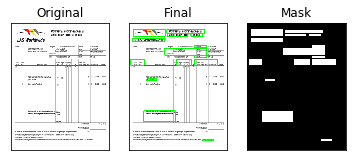

[==================================================================] 113 of 113


21 regions left.


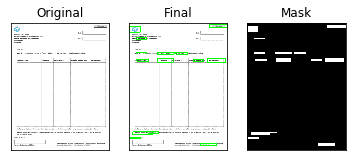

[==================================================================] 670 of 670


276 regions left.


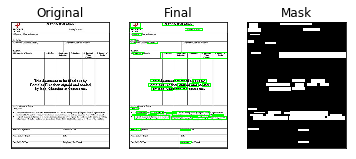

[==================================================================] 550 of 550


305 regions left.


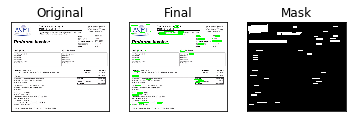

[================================================================] 1039 of 1039


286 regions left.


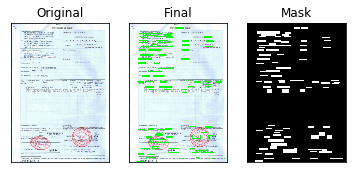

[==================================================================] 624 of 624


225 regions left.


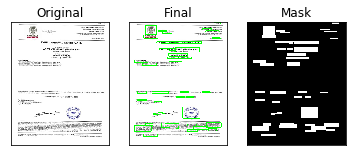

[==================================================================] 357 of 357


87 regions left.


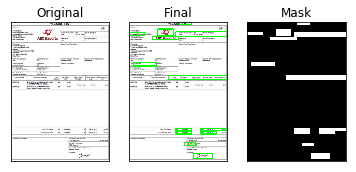

[==================================================================] 601 of 601


146 regions left.


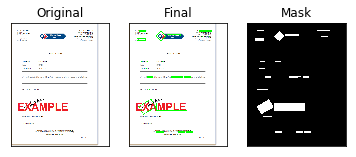

[==================================================================] 853 of 853


98 regions left.


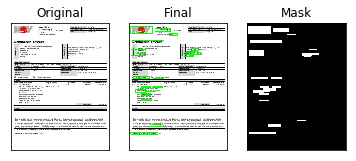

[================================================================] 2335 of 2335


935 regions left.


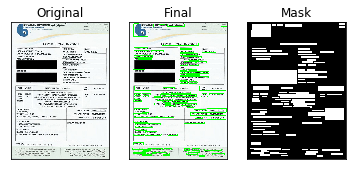

[==================================================================] 111 of 111


20 regions left.


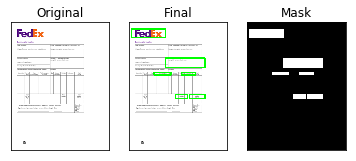

[==================================================================] 227 of 227


14 regions left.


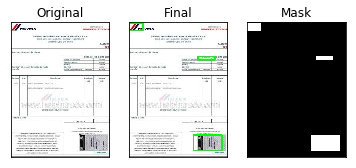

[====================================================================] 91 of 91


2 regions left.


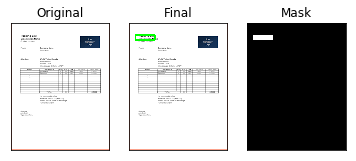

[====================================================================] 70 of 70


17 regions left.


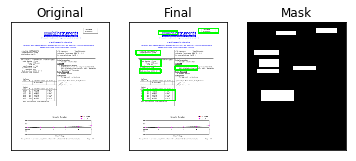

In [7]:
for filename in files_to_test:
    td = TextDetection(filename)
    res = td.detect()
    #mask = cv2.bitwise_not(res)
    #masked = cv2.bitwise_or(td.img,td.img,mask = mask)
    pltShow((td.img, "Original"), (td.final, "Final"), (res, "Mask"))

In [31]:
def longestChild(contours, hierarchy):
    # Find the longest contour
    length_longest = 0
    # Index to iterate through the hierarchy of the contours
    i = 0
    # Initially the longest contour is not found
    longest_contour_idx = None
    for contour in contours:
        # Check that the contour has no children
        # hierarchy[i][2] contains the index of the first child
        # it is set to -1 if the contour has no children
        if hierarchy[0][i][2] == -1:
            # Check the length of the contour and update
            # the longest contour, if appropriate
            length = cv2.arcLength(contour, True)
            if length>length_longest:
                length_longest = length
                longest_contour_idx = i
        i+=1
    # If a contour without children was not found trigger an error
    assert longest_contour_idx!=None, 'Contour not found'
    return longest_contour_idx

# Find the contours on the document - logo is usually the largest connected component
# with the longest contour. Uses the assumption that a logo contour will have no 
# children in the hierarchy
for filename in files_to_test:
    img = cv2.imread(filename)
    # Use a Gaussian filter to reduce the noise
    blur = cv2.GaussianBlur(img,(5,5),0)
    imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    
    # set up a threshold for finding contours
    thresh = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    # find the contours and return the hierarchy in a tree form
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    longest_contour_idx = longestChild(contours, hierarchy)
    # draw the longest contour without children and show it
    cv2.drawContours(img, contours, longest_contour_idx, (0,255,0), 3)
    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()    

In [ ]:
# Try clustering with just the saturation value
for filename in files_to_retest:
    readClusterShow(filename)

In [13]:
# Read all images into a list
image_list = []
for ext in ["jpg","gif","png"]:
    for filename in glob.glob('C:/users/szyma/Documents/Data Science projects/Logos/logo_images/*.%s' % ext) : #assuming png
        img = cv2.imread(filename)
        image_list.append(img)

In [24]:
# For each pixel create a vector containing its distance from ends of Lightness spectrum, 
# Saturation and x- and y-coordinates
def pixelVectors(hls):
    row_idx = 0
    column_idx = 0
    # Create an empty matrix for storing pixel data
    pixel_data = np.zeros([len(hls), len(hls[0]), 3])
    for row in hls:
        for pixel in row:
            # Put the vector for that pixel in the matrix
            # To create the vector, use the saturation, distance from the end of lightness spectrum and 
            # coordinates. pixel[1] contains lighntess, pixel[2] saturation
            pixel_data[row_idx][column_idx] = [pixel[2],column_idx,row_idx]
            column_idx+=1
        column_idx = 0
        row_idx+=1
    # Flatten the matrix with the pixel data into a list of vectors
    pixel_data = pixel_data.reshape(len(pixel_data)*len(pixel_data[0]), len(pixel_data[0][0]))
    return pixel_data

# Normalise the vectors using means and standard deviations
def normalisePixels(pixel_data):
    means = np.mean(pixel_data, axis=0)
    stds = np.std(pixel_data, axis=0)
    normed_pixels = []
    for row in pixel_data:
        normed_pixels.append((row-means)/stds)
    return normed_pixels,means,stds

# The cluster with the logo is the one with higher Saturation 
# this chooses colourful regions over black and white
def findLogoCluster(cluster_centers):
    if (cluster_centers[0][0]) > (cluster_centers[1][0]):
        logo_cluster = 0
    else:
        logo_cluster = 1
    return logo_cluster

# With neon green points mark on the original image what 
# points are in the cluster identified as the logo
neon_green = [57, 255, 20]
def showLogoCluster(normed_pixels, kmeans, means, stds, img):
    for point in normed_pixels:
        # Convert to the original points using the means and standard deviations
        if kmeans.predict([point]) == logo_cluster:
            # If belongs to the logo cluster find the location on the original
            # image and change it to neon green
            # First check it is not outside of the image length (rouning error)
            if point[1]*stds[1]+means[1] > len(img)-2:
                xcoord = len(img)-1
            else:
                xcoord = point[1]*stds[1]+means[1]
            if point[2]*stds[2]+means[2] > len(img[0])-2:
                ycoord = len(img[0])-1
            else:
                ycoord = point[2]*stds[2]+means[2]
            # Change colour to neon green
            img[int(round(ycoord)), int(round(xcoord))] = neon_green
    cv2.imshow('img',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()    

def readClusterShow(filename):
    # Read image
    img = cv2.imread(filename)
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    # Get the vectors for clustering
    pixel_data = pixelVectors(hls)
    normed_pixels, means, stds = normalisePixels(pixel_data)
    # Run K-means clustering on the normalised vectors
    # Assume 2 clusters - one for logo and one for the rest of the document
    kmeans = KMeans(n_clusters=2, random_state=0).fit(normed_pixels)
    cluster_centers = kmeans.cluster_centers_
    print(cluster_centers*stds+means)
    logo_cluster = findLogoCluster(cluster_centers)
    showLogoCluster(normed_pixels, kmeans, means, stds, img)